# Kmeans Clustering on Wine Dataset

https://github.com/jasonj-hong/Unsupervised

The goal of this project is to use an unsupervised learning method to group similar wines and evaluate the clusters against provided customer segment. The dataset I'm using is a list of chemical attributes of the wine which are continuous numerical features and therefore would be perfect to use for K means clustering. 

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from scipy.stats import mode

df = pd.read_csv('../Data/Wine.csv')
df.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


### EDA

Here is the list of wine features in the dataset:
- Alcohol:	The percentage of alcohol content in the wine (higher = stronger wine)
- Malic_Acid:	A type of acid naturally found in grapes, gives tartness/sourness 
- Ash:	Minerals left over after burning the wine (measures total mineral content)
- Ash_Alcanity:	The alkalinity (pH-related property) of ash; reflects the wine's buffer capacity (affects taste balance)
- Magnesium:	A mineral found in wine, related to vine health and wine stability
- Total_Phenols:	Total amount of phenolic compounds (important for color, flavor, aging)
- Flavanoids:	A subgroup of phenols, linked to bitterness, astringency (dry feeling), and antioxidant properties
- Nonflavanoid_Phenols:	Phenolic compounds not classified as flavonoids; contribute differently to flavor and stability
- Proanthocyanins:	Complex molecules affecting astringency, bitterness, and color stability during wine aging
- Color_Intensity:	How deep or dark the color of the wine is (higher = more intense color)
- Hue:	The shade or tint of the wine color (e.g., more towards red or brown tones as wine ages).
- OD280:	Optical Density at 280 nm: a UV absorbance measure of wine, related to the amount of phenolic compounds (linked to body and quality)
- Proline:	An amino acid naturally found in wines; higher levels often correlate with higher-quality wines (indicator of fermentation and flavor development)

From basic exploratory data analysis, I notice that there are no missing values and no obvious outlier data that we need to remove. However, I notice that the values for certain features are in vastly different scale. For example, The min/max for Magnesium is 70 and 162 while the min max for Nonflavanoid_Phenols is 0.13 and 0.66. Fortunately, these are all numerical features and can be addressed in the preprocessing phase of unsupervised learning. And based on the pairwise plot and correlation heatmap, no two features are strongly correlated with an exception of flavanoids with total_phenols. 

Dataset contains 178 samples and 15 features.
Alcohol                 0
Malic_Acid              0
Ash                     0
Ash_Alcanity            0
Magnesium               0
Total_Phenols           0
Flavanoids              0
Nonflavanoid_Phenols    0
Proanthocyanins         0
Color_Intensity         0
Hue                     0
OD280                   0
Proline                 0
Customer_Segment        0
Cluster                 0
dtype: int64
          Alcohol  Malic_Acid         Ash  Ash_Alcanity   Magnesium  \
count  178.000000  178.000000  178.000000    178.000000  178.000000   
mean    13.000618    2.336348    2.366517     19.494944   99.741573   
std      0.811827    1.117146    0.274344      3.339564   14.282484   
min     11.030000    0.740000    1.360000     10.600000   70.000000   
25%     12.362500    1.602500    2.210000     17.200000   88.000000   
50%     13.050000    1.865000    2.360000     19.500000   98.000000   
75%     13.677500    3.082500    2.557500     21.50000

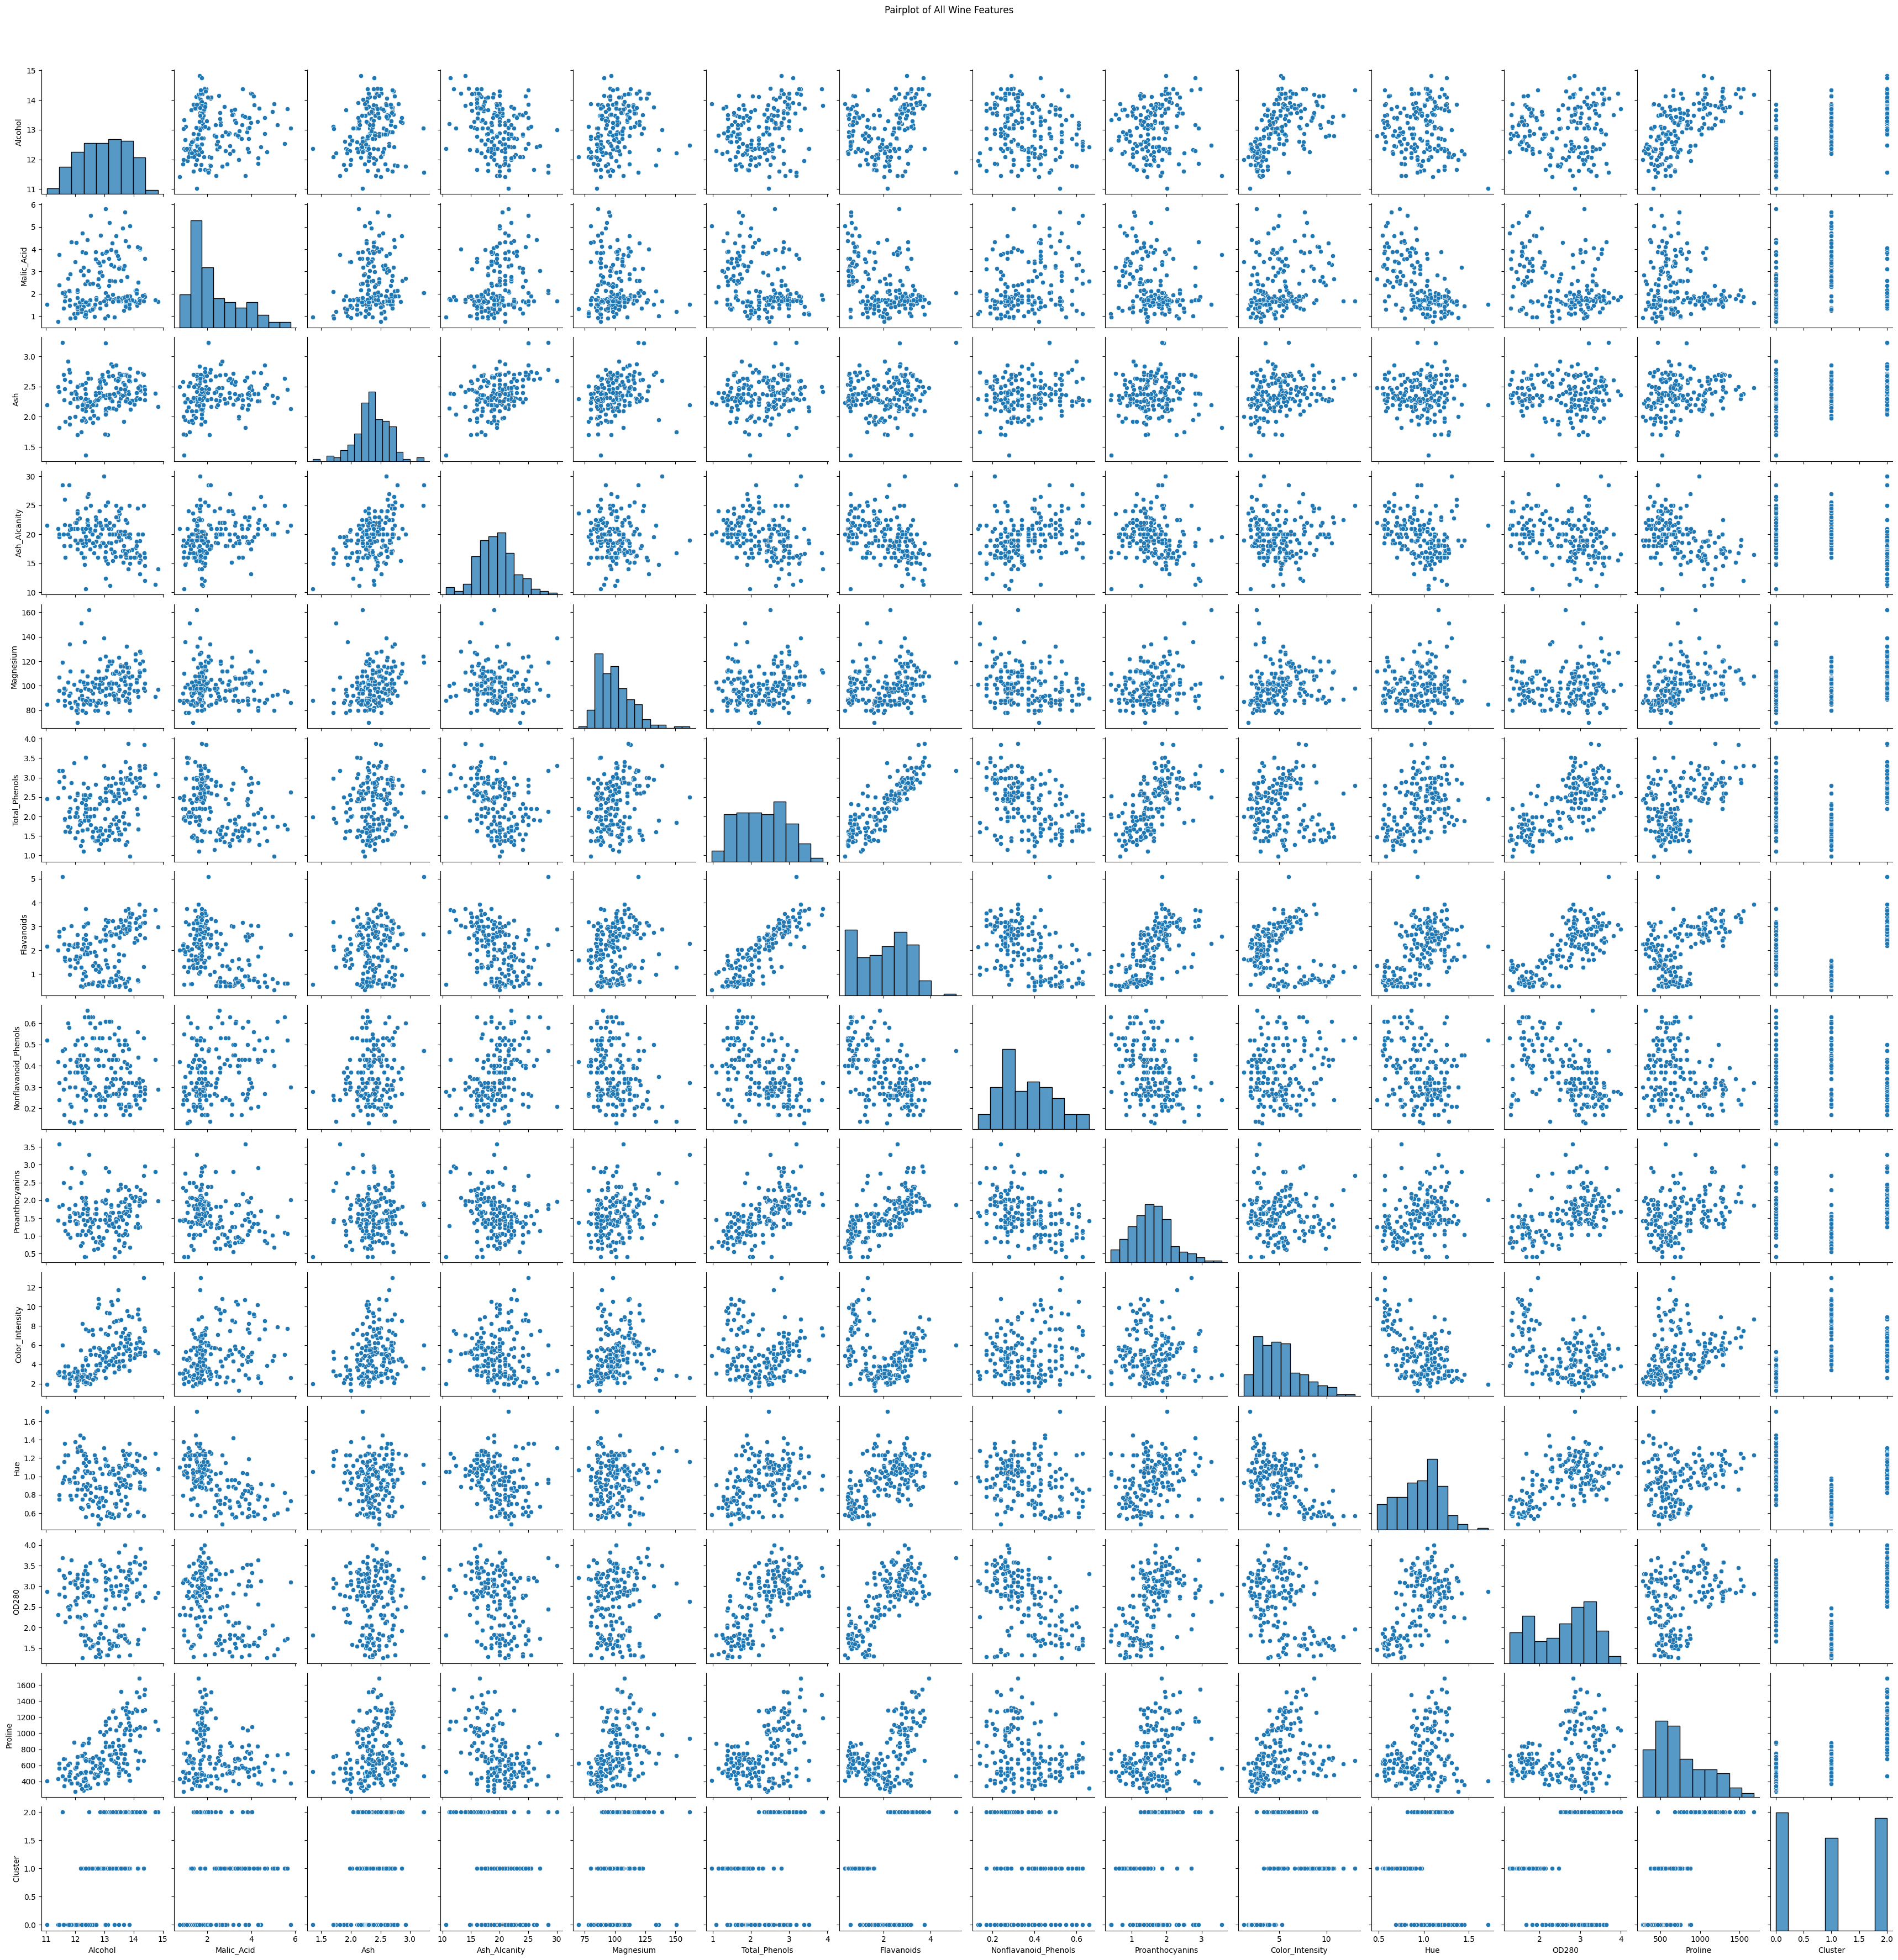

In [12]:
rows = df.shape[0]
columns = df.shape[1]

print(f"Dataset contains {rows} samples and {columns} features.")
print(df.isnull().sum())
print(df.describe())

feature_cols = df.drop('Customer_Segment', axis=1)

sns.pairplot(feature_cols)
plt.suptitle('Pairplot of All Wine Features', y=1.02)
plt.show()

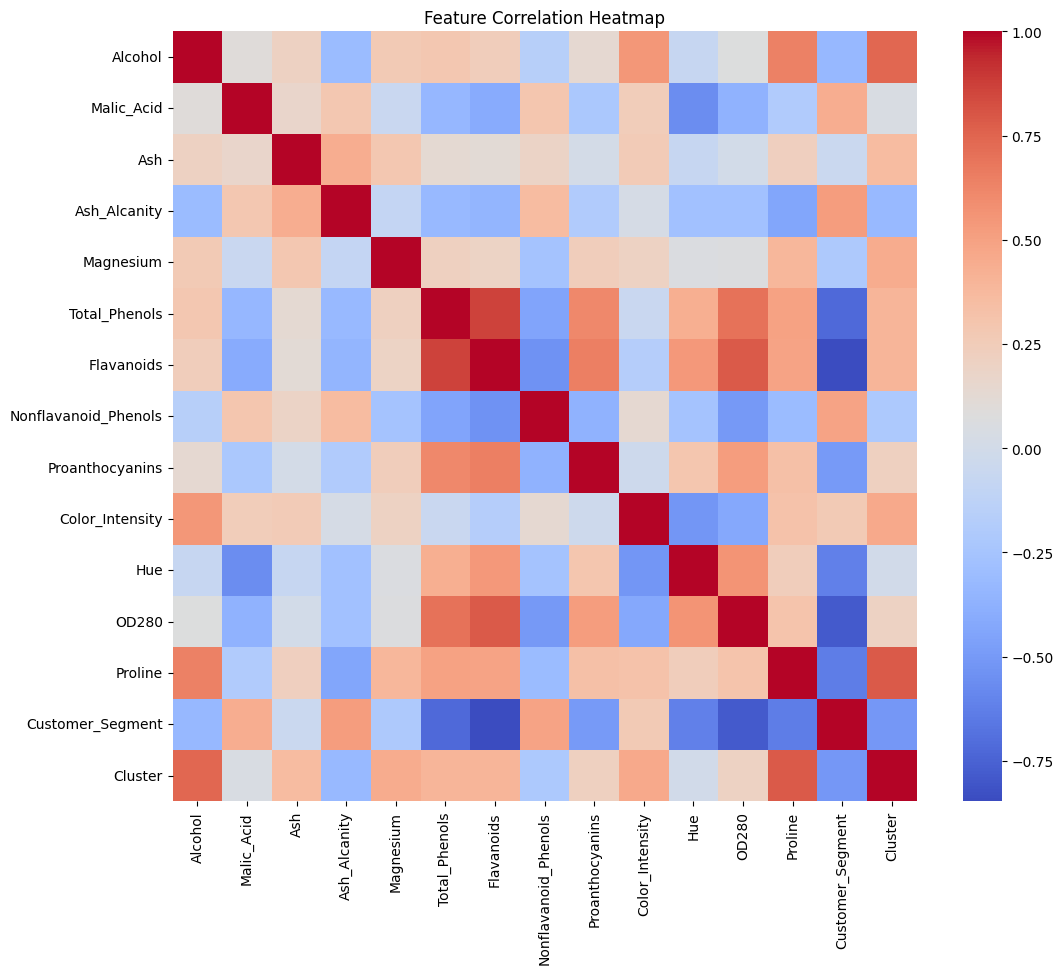

In [11]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

### Preprocessing

Dropping Customer_segment column in the dataframe since this is unsupervised learning. Using StandardScaler to standardize the scale of features.  

In [23]:
X = df.drop('Customer_Segment', axis=1)

scaler = StandardScaler()

### Analysis (Model Building and Training)

Using n-clusters 3 since we know from EDA that the dataset has 3 customer segments. The elbow method to validate k=3 which is consistent with what we know from our truth data (there are 3 customer_segments).

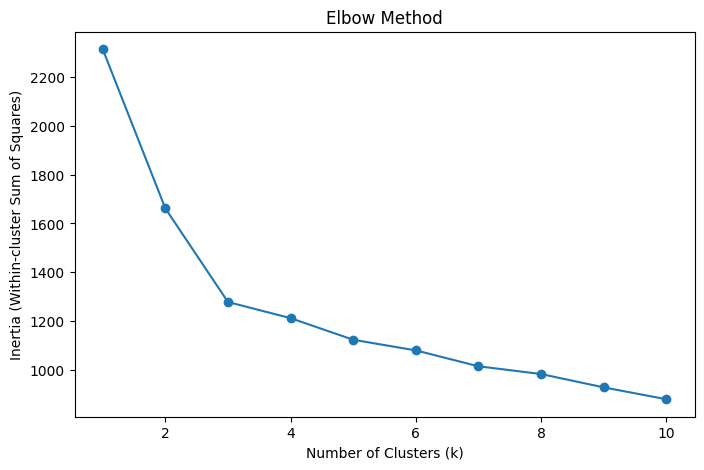

In [22]:
X_scaled = scaler.fit_transform(X)
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster Sum of Squares)')
plt.title('Elbow Method')
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)

df['Cluster'] = kmeans.labels_

### Results

Since Kmeans clusters assigns arbirary labels, I'm mapping clusters to customer segment values using mode matching. And the Adjusted Rand Index that measures clustering accuracy against true labels was high at a value of 0.897. Based on the confusion matrix, it looks like the features between groups 1 and 2 are decently far apart as they were not mistaken for one another but 3 wines of customer segment 2 were confused for 1 and nother 3 wines of customer segment 2 were confused for 3. 

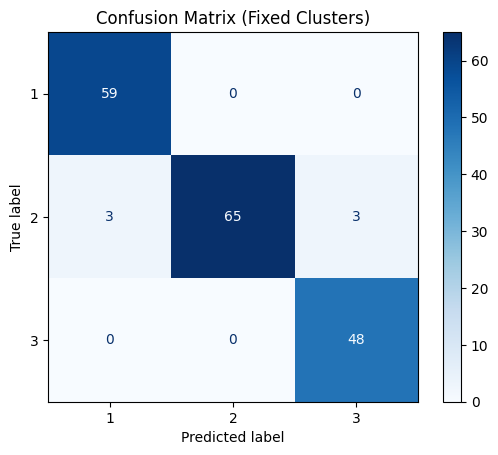


Adjusted Rand Index (ARI): 0.897


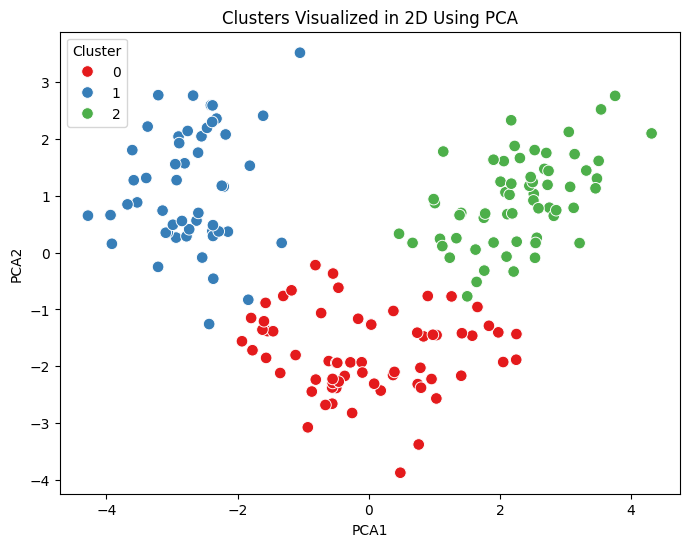

In [21]:
# Map KMeans cluster labels to match customer segments (1 2 3 instead of 0 1 2)
labels = np.zeros_like(df['Cluster'])
for i in range(3):
    mask = (df['Cluster'] == i)
    labels[mask] = mode(df['Customer_Segment'][mask], keepdims=True).mode

conf_mat = confusion_matrix(df['Customer_Segment'], labels)
ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=[1, 2, 3]).plot(cmap='Blues')

plt.title('Confusion Matrix')
plt.show()

ari = adjusted_rand_score(df['Customer_Segment'], df['Cluster'])
print(f"\nAdjusted Rand Index (ARI): {ari:.3f}")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame({
    'PCA1': X_pca[:,0],
    'PCA2': X_pca[:,1],
    'Cluster': df['Cluster']
})

plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set1', s=70)
plt.title('Clusters Visualized in 2D Using PCA')
plt.show()

### Conclusion

Kmeans clustering was able to successfully identify groupings in the wine dataset with decent accuracy. This supports the idea that the chemical attributes of the wines are strong indicators of customer segments. We can conclude that the 13 provided chemical features strongly separate wines into distinguishable groups. However, without knowing true value (specific chemical attributes for specific customer segments), there is no way to know which cluster is which customer segment. KMeans is able to group them but doesn't know true labels as a limitation of unsupervised learning. Another limitation is that Kmeans groups data in spherical clusters but not all data will be grouped in that shape. Reducing dimensionality into 2D and making it simple by using PCA1 vs PCA2, it was able to work for this dataset with decent accuracy but projecting the 13 feature data onto a higher dimensional plane may better capture the data. 